# Determining the Primary Causes of Traffic Accidents in Chicago

This projects raw dataset originates from the [City of Chicago's website](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data), where it is updated daily. I downloaded the data on May 1st, 2024 and [uploaded that snapshot to Kaggle](https://www.kaggle.com/datasets/joelmott/chicago-traffic-crashes-may-2024).

This dataset consists of three seperate csv files: one for general crash information, one for the people involved in each crash, and one for each vehicle. When merged, the resulting dataset contains over 150 columns and 3.8 million records. In order to improve modeling results and interpretability, I narrowed that down to 15 feature columns and one target column in this [data engineering notebook](https://github.com/joeldmott/chicago_auto_accidents_project/blob/main/data_engineering_notebook.ipynb).

In this project, I use the resulting csv file from that data engineering effort.

In [1]:
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# api key for the json object below
api_key = userdata.get('API_KEY')

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
#importing Kaggle module and downloading pre-engineered csv file
import kaggle
! kaggle datasets download joelmott/chicago-traffic-crashes-may-2024 -f trimmed_chicago_crashes_data.csv

Dataset URL: https://www.kaggle.com/datasets/joelmott/chicago-traffic-crashes-may-2024
License(s): CC0-1.0
 66% 7.00M/10.6M [00:00<00:00, 71.2MB/s]
100% 10.6M/10.6M [00:00<00:00, 91.7MB/s]


In [3]:
!unzip /content/trimmed_chicago_crashes_data.csv

Archive:  /content/trimmed_chicago_crashes_data.csv.zip
  inflating: trimmed_chicago_crashes_data.csv  


In [4]:
#reading file in as a DataFrame
import pandas as pd
df = pd.read_csv('/content/trimmed_chicago_crashes_data.csv')
df.head()

,Unnamed: 0,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,PERSON_TYPE,SEX,AGE,TRAVEL_DIRECTION,MANEUVER,TARGET
0,0,30,CLEAR,DAYLIGHT,DRY,2,17,6,8,41.942976,-87.761883,BICYCLE,M,14,S,STRAIGHT AHEAD,1
1,1,30,CLEAR,DAYLIGHT,DRY,2,17,6,8,41.942976,-87.761883,DRIVER,M,36,S,STRAIGHT AHEAD,1
2,2,15,CLEAR,DAYLIGHT,DRY,2,12,4,9,41.744152,-87.585945,DRIVER,M,55,W,BACKING,1
3,3,15,CLEAR,DAYLIGHT,DRY,2,12,4,9,41.744152,-87.585945,DRIVER,M,55,S,SLOW/STOP IN TRAFFIC,1
4,4,30,CLEAR,DAYLIGHT,DRY,2,11,4,9,41.937252,-87.776321,DRIVER,M,39,S,STRAIGHT AHEAD,1


In [5]:
#A new index column was added in for some reason, let's drop that
df.drop('Unnamed: 0', axis=1, inplace=True)
#Now let's check and see if it looks like it did back in the data engineering notebook:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884772 entries, 0 to 884771
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   POSTED_SPEED_LIMIT    884772 non-null  int64  
 1   WEATHER_CONDITION     884772 non-null  object 
 2   LIGHTING_CONDITION    884772 non-null  object 
 3   ROADWAY_SURFACE_COND  884772 non-null  object 
 4   NUM_UNITS             884772 non-null  int64  
 5   CRASH_HOUR            884772 non-null  int64  
 6   CRASH_DAY_OF_WEEK     884772 non-null  int64  
 7   CRASH_MONTH           884772 non-null  int64  
 8   LATITUDE              884772 non-null  float64
 9   LONGITUDE             884772 non-null  float64
 10  PERSON_TYPE           884772 non-null  object 
 11  SEX                   884772 non-null  object 
 12  AGE                   884772 non-null  int64  
 13  TRAVEL_DIRECTION      884772 non-null  object 
 14  MANEUVER              884772 non-null  object 
 15  

## valuation measures

This file is more managable than the gargantuan raw data, but still contains plenty of records. Subsequently, we'll validate this project using a train-test split as opposed to cross-validation.

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=210)

## preprocessing data

Now we can standardize our numeric columns and one-hot encode our categorical ones before inputting these features into models.

In [7]:
#establishing which features are numeric or categorical
numeric_features = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'CRASH_HOUR', 'LATITUDE', 'LONGITUDE', 'AGE']

categorical_features = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
                        'CRASH_DAY_OF_WEEK', 'PERSON_TYPE', 'SEX', 'TRAVEL_DIRECTION', 'MANEUVER']

#splitting them up for preprocessing
X_train_numeric = X_train[numeric_features]
X_train_categorical = X_train[categorical_features]

First, we'll standardize the numeric features since they have varied scales that throw off measures like PCA.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled,
                                      columns = X_train_numeric.columns,
                                      index = X_train_numeric.index)
X_train_numeric_scaled.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE
571273,0.132509,1.141696,-1.013182,0.107484,-0.085609,-1.109211
751169,0.132509,-0.333483,-1.013182,-0.112652,-0.012405,0.459883
43397,0.132509,1.141696,-2.335921,-0.233132,0.113552,-1.046447
847787,0.132509,-0.333483,1.254371,0.310612,-0.137801,-1.485793
542731,0.132509,-0.333483,-0.068368,0.106912,0.022791,0.397120


Looks good; let's one-hot encode the categorical variables. Since we'll be using regularization to optimize our models, we won't need to drop one of the resulting dummy variables. This will help with model interpretability.

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
X_train_categorical_ohe = ohe.fit_transform(X_train_categorical)
X_train_categorical_ohe = pd.DataFrame(X_train_categorical_ohe,
                                       columns = ohe.get_feature_names_out(),
                                       index = X_train_categorical.index)
X_train_categorical_ohe.head()

,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
571273,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
751169,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
847787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
542731,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_categorical_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707817 entries, 571273 to 303626
Data columns (total 63 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT   707817 non-null  float64
 1   WEATHER_CONDITION_BLOWING SNOW               707817 non-null  float64
 2   WEATHER_CONDITION_CLEAR                      707817 non-null  float64
 3   WEATHER_CONDITION_CLOUDY/OVERCAST            707817 non-null  float64
 4   WEATHER_CONDITION_FOG/SMOKE/HAZE             707817 non-null  float64
 5   WEATHER_CONDITION_FREEZING RAIN/DRIZZLE      707817 non-null  float64
 6   WEATHER_CONDITION_RAIN                       707817 non-null  float64
 7   WEATHER_CONDITION_SEVERE CROSS WIND GATE     707817 non-null  float64
 8   WEATHER_CONDITION_SLEET/HAIL                 707817 non-null  float64
 9   WEATHER_CONDITION_SNOW                       707817 non-nul

In [10]:
X_train_preprocessed = pd.concat([X_train_numeric_scaled, X_train_categorical_ohe], axis=1)
X_train_preprocessed.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
571273,0.132509,1.141696,-1.013182,0.107484,-0.085609,-1.109211,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
751169,0.132509,-0.333483,-1.013182,-0.112652,-0.012405,0.459883,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43397,0.132509,1.141696,-2.335921,-0.233132,0.113552,-1.046447,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
847787,0.132509,-0.333483,1.254371,0.310612,-0.137801,-1.485793,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
542731,0.132509,-0.333483,-0.068368,0.106912,0.022791,0.397120,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_preprocessed.shape

(707817, 69)

That's still too many columns, but I can't drop any more in good conscience without further information. Let's make use of Principal Component Analysis (PCA) to which features are more significant.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(random_state=210)
pca_array = pca.fit_transform(X_train_preprocessed)
pca_array

array([[-1.33546501e-01,  8.37875659e-01,  1.33035957e+00, ...,
         1.63263119e-14, -1.04521151e-14, -2.72348349e-15],
       [ 7.45724224e-02, -7.11396080e-01,  8.67243498e-01, ...,
         1.05148879e-14,  2.63398316e-14,  1.47182162e-14],
       [ 2.52991872e-01,  6.12658192e-01,  2.25054622e+00, ...,
        -5.80594613e-15,  2.23024165e-14, -5.40001772e-15],
       ...,
       [ 1.01928195e-01, -1.02117000e+00,  9.33134998e-01, ...,
        -3.65539377e-17, -5.19572472e-18,  4.14075590e-17],
       [ 3.49421039e-01,  7.03979332e-02, -3.70697133e-01, ...,
        -1.68710620e-17, -2.08849482e-17,  2.59569713e-17],
       [ 2.53640988e-01, -5.58348152e-01, -2.24439449e-01, ...,
        -1.06584771e-17,  3.39795214e-17,  6.76586431e-17]])

In [ ]:
len(pca_array)

707817

Now that we've fit PCA to our training data, let's see how much of the variance it explains by adding up each row's explained variance ratio.

In [ ]:
import numpy as np
evr = pca.explained_variance_ratio_
np.cumsum(evr)

array([0.19978425, 0.31013649, 0.41337286, 0.51236511, 0.60727314,
       0.65673974, 0.70265202, 0.73364186, 0.761715  , 0.78651999,
       0.81021641, 0.83299294, 0.84940415, 0.86419541, 0.87883346,
       0.89324448, 0.90712431, 0.91875691, 0.92827092, 0.93730983,
       0.94387062, 0.95010009, 0.95578929, 0.95976791, 0.9634321 ,
       0.96693294, 0.9703201 , 0.9734249 , 0.97594635, 0.97837396,
       0.98069592, 0.98257593, 0.98431272, 0.98593332, 0.98754699,
       0.98909716, 0.9904115 , 0.99161978, 0.99270955, 0.99375646,
       0.99457928, 0.99538291, 0.99606826, 0.99665373, 0.99716292,
       0.99765165, 0.99800998, 0.9983545 , 0.99863401, 0.99884497,
       0.99905226, 0.99922076, 0.99938749, 0.99952536, 0.99964994,
       0.99977387, 0.99988918, 0.99996568, 0.9999844 , 0.99999953,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

Not great, let's check out the loadings to see how the features contribute.

In [ ]:
loadings = pca.components_
print('Loadings shape:', loadings.shape)
print(np.around(loadings, decimals=3))

Loadings shape: (69, 69)
[[ 0.005  0.004 -0.001 ...  0.    -0.     0.   ]
 [ 0.605  0.554  0.308 ... -0.003 -0.006 -0.   ]
 [ 0.166  0.43  -0.866 ... -0.01  -0.004 -0.001]
 ...
 [ 0.     0.    -0.    ...  0.14   0.14   0.14 ]
 [-0.    -0.     0.    ...  0.075  0.075  0.075]
 [ 0.     0.    -0.    ... -0.013 -0.013 -0.013]]


Below, we run a plot to see where the explained variance reaches a point of diminishing returns as the number of components continues to increase. It looks like that threshold takes place right around 21 components.

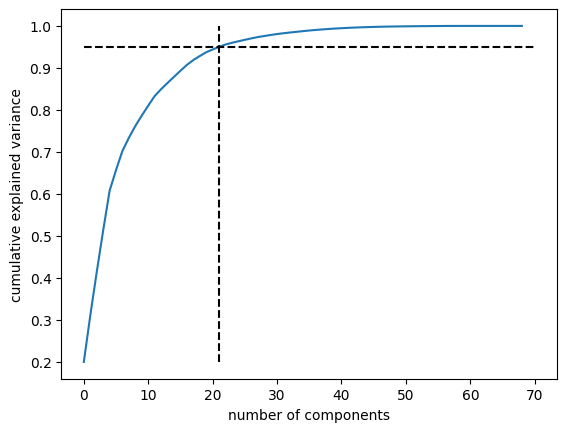

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.cumsum(evr))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.hlines(y=0.95, xmin=0, xmax=70, color='k', linestyle='--')
plt.vlines(x=21, ymin=0.2, ymax=1, color='k', linestyle='--');

Let's rerun PCA with this optimal components parameter in mind.

In [ ]:
pca = PCA(n_components=21, random_state=210)
pca_array = pca.fit_transform(X_train_preprocessed)
evr = pca.explained_variance_ratio_
np.cumsum(evr)

array([0.19978425, 0.31013649, 0.41337286, 0.51236511, 0.60727314,
       0.65673974, 0.70265202, 0.73364186, 0.761715  , 0.78651999,
       0.81021641, 0.83299294, 0.84940415, 0.86419541, 0.87883346,
       0.89324448, 0.90712431, 0.9187569 , 0.92827092, 0.93730982,
       0.94387058])

In [ ]:
loadings = pca.components_
print('Loadings shape:', loadings.shape)
print(np.around(loadings, decimals=3))

Loadings shape: (21, 69)
[[ 0.005  0.004 -0.001 ...  0.    -0.     0.   ]
 [ 0.605  0.554  0.308 ... -0.003 -0.006 -0.   ]
 [ 0.166  0.43  -0.866 ... -0.01  -0.004 -0.001]
 ...
 [-0.002 -0.025  0.002 ... -0.588 -0.043 -0.006]
 [ 0.009  0.009  0.007 ...  0.172  0.016 -0.   ]
 [ 0.003 -0.    -0.026 ... -0.086  0.034  0.002]]


In [ ]:
loadings_rounded = np.around(loadings, decimals=3)
loadings_df = pd.DataFrame(loadings_rounded,columns=X_train_preprocessed.columns)
loadings_sums = pd.Series(loadings_df.sum()).sort_values(key=abs)
print(loadings_sums.to_string())

PERSON_TYPE_NON-CONTACT VEHICLE                0.000
WEATHER_CONDITION_SEVERE CROSS WIND GATE       0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT     0.000
SEX_X                                          0.000
MANEUVER_PARKED IN TRAFFIC LANE               -0.001
MANEUVER_NEGOTIATING A CURVE                  -0.002
MANEUVER_SLOW/STOP - LOAD/UNLOAD              -0.003
MANEUVER_DRIVING WRONG WAY                    -0.003
MANEUVER_SLOW/STOP - RIGHT TURN               -0.003
MANEUVER_SLOW/STOP - LEFT TURN                -0.005
MANEUVER_AVOIDING VEHICLES/OBJECTS            -0.005
MANEUVER_LEAVING TRAFFIC LANE TO PARK         -0.008
WEATHER_CONDITION_BLOWING SNOW                 0.009
WEATHER_CONDITION_FOG/SMOKE/HAZE               0.009
MANEUVER_ENTER FROM DRIVE/ALLEY               -0.014
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE        0.016
WEATHER_CONDITION_SLEET/HAIL                   0.016
MANEUVER_U-TURN                               -0.018
MANEUVER_STARTING IN TRAFFIC                  

A wide range of cumulative explained variance ratios appear for these columns with the occasional large leap between groups. Those that appear to explain variance better include Sunday crashes, (somewhat surprisingly) crashes when the manuever beforehand was simply driving straight, as well as some weather and road condition columns.

On the other side of the spectrum, we see a lot of rare classes from categorical columns. While I got rid of many columns that showed this kind of skewed distribution, these were a little better than most and seemed like they could still hold some pertitent information in regard to crash causes.

Let's begin by dropping any column that can't explain at least a *cumulative* absolute value of 0.1 of the variance. Below, we see that this will help trim our features down by just over half to 31. (Below, "e.v.r." stands for "explained variance ratio".)

In [ ]:
loadings_sums_abs = loadings_sums.abs()
less_explanatory_loadings_sums = loadings_sums_abs[loadings_sums_abs < 0.1]
print('ratio of features below/above 0.1 cumulative e.v.r.:   ', round(len(less_explanatory_loadings_sums)/len(loadings_sums), 2))
print('remaining number of features after dropping those below 0.1 cumulative e.v.r.:   ', len(loadings_sums) - len(less_explanatory_loadings_sums))

ratio of features below/above 0.1 cumulative e.v.r.:    0.55
remaining number of features after dropping those below 0.1 cumulative e.v.r.:    31


In [ ]:
loadings_sums.index

Index(['PERSON_TYPE_NON-CONTACT VEHICLE',
       'WEATHER_CONDITION_SEVERE CROSS WIND GATE',
       'WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT', 'SEX_X',
       'MANEUVER_PARKED IN TRAFFIC LANE', 'MANEUVER_NEGOTIATING A CURVE',
       'MANEUVER_SLOW/STOP - LOAD/UNLOAD', 'MANEUVER_DRIVING WRONG WAY',
       'MANEUVER_SLOW/STOP - RIGHT TURN', 'MANEUVER_SLOW/STOP - LEFT TURN',
       'MANEUVER_AVOIDING VEHICLES/OBJECTS',
       'MANEUVER_LEAVING TRAFFIC LANE TO PARK',
       'WEATHER_CONDITION_BLOWING SNOW', 'WEATHER_CONDITION_FOG/SMOKE/HAZE',
       'MANEUVER_ENTER FROM DRIVE/ALLEY',
       'WEATHER_CONDITION_FREEZING RAIN/DRIZZLE',
       'WEATHER_CONDITION_SLEET/HAIL', 'MANEUVER_U-TURN',
       'MANEUVER_STARTING IN TRAFFIC', 'MANEUVER_SKIDDING/CONTROL LOSS',
       'PERSON_TYPE_BICYCLE', 'MANEUVER_MERGING', 'PERSON_TYPE_PEDESTRIAN',
       'MANEUVER_ENTERING TRAFFIC LANE FROM PARKING', 'TRAVEL_DIRECTION_SW',
       'TRAVEL_DIRECTION_NE', 'TRAVEL_DIRECTION_NW', 'PERSON_TYPE_DRIVER',
 

In [11]:
#dropping less explanatory features
explanatory_loadings_sums = loadings_sums.drop(less_explanatory_loadings_sums.index, axis=0)
explanatory_loadings_sums

NameError: name 'loadings_sums' is not defined

This is one way to find our most promising features and get them down to a more reasonable quanitity before running them through a predictive model.

We can also try a similar process by way of a random forest. Once fit to our preprocessed training data, we can expect it's feature importances and see how well it matches our more promising features from PCA above.

## random forest feature importance

Since a random forest is a predictive model, we'll have to contend with the target column's class imbalance. Let's check and see how it appears here in our training data:

In [ ]:
y_train.value_counts(normalize=True)

TARGET
1    0.928116
0    0.071884
Name: proportion, dtype: float64

Not good, but it could be much worse. Subsequently, we'll have to run our random forests with oversampling, undersampling, and SMOTE sampling strategies to get the best picture on which set of feature importances work best.

Before doing that, let's establish a baseline random forest model without any sampling strategies. This tree-based model will need the one-hot encoded categorical values, but the non-standardized numeric data.

In [12]:
X_train_nonstandardized = pd.concat([X_train_numeric, X_train_categorical_ohe], axis=1)
X_train_nonstandardized.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
571273,30,3,8,41.898626,-87.743733,22,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
751169,30,2,8,41.808323,-87.682079,47,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43397,30,3,1,41.758900,-87.575996,23,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
847787,30,2,20,41.981952,-87.787690,16,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
542731,30,2,13,41.898391,-87.652436,46,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

#instantiating the random forest classifier
forest = RandomForestClassifier(random_state=210)

#Since this dataset has target class imbalance, let's
# evaluate its performance via an f1 score instead of the
# default accuracy.
f1 = make_scorer(f1_score)

#establishing a parameter grid for GridSearchCV
rf_param_grid = {'n_estimators':[5, 10],
                 'criterion':['entropy'],
                 'max_depth':[None, 4],
                 'min_samples_split':[10]}

#instantiating GridSearchCV
rf_grid_search = GridSearchCV(forest,
                              rf_param_grid,
                              cv=5,
                              return_train_score=True,
                              scoring=f1)

#fitting the GridSearch to the training data
rf_grid_search.fit(X_train_nonstandardized, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=210),
             param_grid={'criterion': ['entropy'], 'max_depth': [None, 4],
                         'min_samples_split': [10], 'n_estimators': [5, 10]},
             return_train_score=True, scoring=make_scorer(f1_score))

Before we can evaluate this random forest grid search on testing data, we have to perform one-hot encoding on X_test while refraining from standardizing its numerical columns in order to have an apples-to-apples evaluation.

In [13]:
#isolating X_test's categorical features
X_test_categorical = X_test[categorical_features]
#transforming them
X_test_categorical_ohe = ohe.transform(X_test_categorical)
#putting them back into a DataFrame
X_test_categorical_ohe = pd.DataFrame(X_test_categorical_ohe,
                                       columns = ohe.get_feature_names_out(),
                                       index = X_test_categorical.index)
#isolating X_test's numeric data
X_test_numeric = X_test[numeric_features]
#concatenating the non-standardized numeric data with the one-hot encoded categorical columns
X_test_nonstandardized = pd.concat([X_test_numeric, X_test_categorical_ohe], axis=1)
#making sure it looks right
X_test_nonstandardized.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,CRASH_HOUR,LATITUDE,LONGITUDE,AGE,"WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT",WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,MANEUVER_SKIDDING/CONTROL LOSS,MANEUVER_SLOW/STOP - LEFT TURN,MANEUVER_SLOW/STOP - LOAD/UNLOAD,MANEUVER_SLOW/STOP - RIGHT TURN,MANEUVER_SLOW/STOP IN TRAFFIC,MANEUVER_STARTING IN TRAFFIC,MANEUVER_STRAIGHT AHEAD,MANEUVER_TURNING LEFT,MANEUVER_TURNING RIGHT,MANEUVER_U-TURN
442162,30,2,17,41.830409,-87.677876,31,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856659,30,2,21,41.960645,-87.762900,51,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534978,30,2,1,41.928408,-87.691399,46,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
185993,30,2,12,41.758096,-87.624208,66,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534322,30,2,7,41.997415,-87.754943,16,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#mean training score
rf_grid_search_train_score = rf_grid_search.cv_results_['mean_train_score'].mean()
#mean test score
rf_grid_search_test_score = rf_grid_search.score(X_test_nonstandardized, y_test)
#printing results
print(f'baseline random forest mean training score: {rf_grid_search_train_score :.2%}')
print(f'baseline random forest mean test score: {rf_grid_search_test_score :.2%}')
print(f'baseline random forest optimal parameter combination:', rf_grid_search.best_params_)

baseline random forest mean training score: 97.08%
baseline random forest mean test score: 96.98%
baseline random forest optimal parameter combination: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 10}


With a baseline that's been optimized via GridSearchCV in mind, let's (hopefully) further improve on this model by adding in some over/under sampling strategies.

In [ ]:
#refresher on current state of y_train's distribution
y_train.value_counts()

TARGET
1    656936
0     50881
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

#defining five over-sampling strategies from 110% to 150% of the
# minority target class in increments of 10%:
oversampling_strategies = [{0:55969, 1:656936}, {0:61057, 1:656936}, {0:66145, 1:656936}, {0:71233, 1:656936}, {0:76322, 1:656936}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in oversampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_nonstandardized_over, y_train_over = oversample.fit_resample(X_train_nonstandardized, y_train)
    #instantiate & fit the model to X-over & y-over with previously optimized parameters
    forest_oversample_temp = RandomForestClassifier(criterion='entropy',
                                    max_depth=None,
                                    min_samples_split=10,
                                    n_estimators=10)
    forest_oversample_temp.fit(X_train_nonstandardized_over, y_train_over)
    #make predictions on test set
    y_hat = forest_oversample_temp.predict(X_test_nonstandardized)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

sampling strategies & f1 scores: [('110%:', 0.9705796765783581), ('120%:', 0.9710119079467561), ('130%:', 0.9713056722314108), ('140%:', 0.9714324844955354), ('150%:', 0.9720466633889062)]


It looks like over-sampling at 150% works best; let's see whether under-sampling will outperform it.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

#defining five under-sampling strategies from 50% to 90% of the
# majority target class in increments of 10%:
undersampling_strategies = [{0:50881, 1:328468}, {0:50881, 1:394162}, {0:50881, 1:459855}, {0:50881, 1:525549}, {0:50881, 1:591252}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in undersampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=210, sampling_strategy=i)
    # fit and apply the undersampling strategy
    X_train_nonstandardized_under, y_train_under = undersample.fit_resample(X_train_nonstandardized, y_train)
    #instantiate & fit the model to X-over & y-over with previously optimized parameters
    forest_undersample_temp = RandomForestClassifier(criterion='entropy',
                                    max_depth=None,
                                    min_samples_split=10,
                                    n_estimators=10)
    forest_undersample_temp.fit(X_train_nonstandardized_under, y_train_under)
    #make predictions on test set
    y_hat = forest_undersample_temp.predict(X_test_nonstandardized)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

undersampling_percentages = ['50%:', '60%:', '70%:', '80%:', '90%:']
print("sampling strategies & f1 scores:", list(zip(undersampling_percentages, f1_scores)))

sampling strategies & f1 scores: [('50%:', 0.9683335129503897), ('60%:', 0.9694421901852205), ('70%:', 0.969655279207166), ('80%:', 0.9700186751359003), ('90%:', 0.9700439482123768)]


So far, it looks like oversampling the minority class at 150% of its original value count produces the highest f1 score. Before investigating this particular model's feature importances, let's try one more sampling strategy by way of SMOTE.

In [ ]:
from imblearn.over_sampling import SMOTE

#empty list for f1 scores
f1_scores = []

#iterate through each SMOTE oversampling strategy
for i in oversampling_strategies:
    smote = SMOTE(random_state=210, sampling_strategy=i)
    # fit the smote-oversampling strategy
    X_train_nonstandardized_smote, y_train_smote = smote.fit_resample(X_train_nonstandardized, y_train)
    #instantiate & fit the random forest model to X-smote & y-smote with previously optimized parameters
    forest_smote_temp = RandomForestClassifier(criterion='entropy',
                                    max_depth=None,
                                    min_samples_split=10,
                                    n_estimators=10)
    forest_smote_temp.fit(X_train_nonstandardized_smote, y_train_smote)
    #make predictions on test set
    y_hat = forest_smote_temp.predict(X_test_nonstandardized)
    #find & append f1 score
    f1_scores.append(f1_score(y_test, y_hat))

smote_oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(smote_oversampling_percentages, f1_scores)))

sampling strategies & f1 scores: [('110%:', 0.9703457142772305), ('120%:', 0.9701238578559614), ('130%:', 0.970251865754751), ('140%:', 0.9701651286743952), ('150%:', 0.9700610544141895)]


It turns out that oversampling the minorty class by 150% is still our best route. Let's examine its feature importances and compare them to our PCA's less_explanatory_loadings_sums variable in order to make a more informed decision on which columns to drop.

In [ ]:
#reestablishing the best random forest model (150% oversampled minority target class data)
oversample = RandomOverSampler(random_state=210, sampling_strategy={0:76322, 1:656936})
X_train_nonstandardized_over, y_train_over = oversample.fit_resample(X_train_nonstandardized, y_train)
final_forest_model = RandomForestClassifier(criterion='entropy',
                                            max_depth=None,
                                            min_samples_split=10,
                                            n_estimators=10)
final_forest_model.fit(X_train_nonstandardized_over, y_train_over)

#gathering its feature importances
forest_feature_importances = final_forest_model.feature_importances_
forest_feature_importances

array([3.69252941e-02, 6.99957878e-02, 8.36572671e-02, 1.58820561e-01,
       1.56825987e-01, 1.13413099e-01, 2.66293827e-07, 5.04365598e-04,
       2.36445524e-02, 3.30422076e-03, 4.82329424e-04, 9.98621951e-04,
       2.64543188e-03, 3.07655707e-04, 6.05253232e-04, 2.51607950e-02,
       4.78292339e-03, 8.46918885e-03, 3.22093779e-03, 8.59733039e-03,
       4.52498662e-03, 2.90626318e-02, 1.47724454e-02, 1.41567814e-02,
       6.36680747e-03, 9.50895890e-03, 1.05351390e-02, 1.05891969e-02,
       1.06294212e-02, 1.03749962e-02, 1.13878943e-02, 1.06216259e-02,
       7.89737653e-04, 2.21387745e-03, 1.75377690e-04, 1.59862984e-03,
       6.79372438e-03, 6.95890084e-03, 2.69120903e-04, 1.14056668e-02,
       1.18314072e-02, 2.38300845e-03, 2.88380095e-03, 1.16918952e-02,
       3.36943322e-03, 2.65312255e-03, 1.13947736e-02, 6.51514441e-03,
       2.99560816e-03, 2.65758603e-03, 6.58744529e-04, 1.48695340e-03,
       1.57847814e-03, 8.30190732e-04, 1.15477076e-03, 8.78705945e-04,
      

In [ ]:
fi_rounded = np.around(forest_feature_importances, decimals=3)
fi_series = pd.Series(fi_rounded, index=X_train_nonstandardized.columns).sort_values(key=abs)
fi_series

PERSON_TYPE_NON-CONTACT VEHICLE               0.000
MANEUVER_SLOW/STOP - RIGHT TURN               0.000
MANEUVER_SLOW/STOP - LOAD/UNLOAD              0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT    0.000
WEATHER_CONDITION_FOG/SMOKE/HAZE              0.000
                                              ...  
NUM_UNITS                                     0.070
CRASH_HOUR                                    0.084
AGE                                           0.113
LONGITUDE                                     0.157
LATITUDE                                      0.159
Length: 69, dtype: float64

Let's get a resfresher on how the PCA evr/loadings looked - below we note how they seem to be working on a different scale because they're the sum of 21 rows-worth of loadings.

In [ ]:
loadings_sums

PERSON_TYPE_NON-CONTACT VEHICLE               0.000
WEATHER_CONDITION_SEVERE CROSS WIND GATE      0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT    0.000
SEX_X                                         0.000
MANEUVER_PARKED IN TRAFFIC LANE              -0.001
                                              ...  
TRAVEL_DIRECTION_S                           -1.179
TRAVEL_DIRECTION_E                            1.202
LIGHTING_CONDITION_DAYLIGHT                  -1.304
NUM_UNITS                                     1.796
CRASH_DAY_OF_WEEK_3                          -2.040
Length: 69, dtype: float64

Subsequently, let's scale them down to their average by dividing them by 21 before comparing them to the random forest's feature importances.

In [ ]:
loadings_sums_scaled = loadings_sums/21
loadings_sums_scaled

PERSON_TYPE_NON-CONTACT VEHICLE               0.000000
WEATHER_CONDITION_SEVERE CROSS WIND GATE      0.000000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT    0.000000
SEX_X                                         0.000000
MANEUVER_PARKED IN TRAFFIC LANE              -0.000048
                                                ...   
TRAVEL_DIRECTION_S                           -0.056143
TRAVEL_DIRECTION_E                            0.057238
LIGHTING_CONDITION_DAYLIGHT                  -0.062095
NUM_UNITS                                     0.085524
CRASH_DAY_OF_WEEK_3                          -0.097143
Length: 69, dtype: float64

Now we can visualize these alongside the PCA loadings to get a better handle on how they compare.

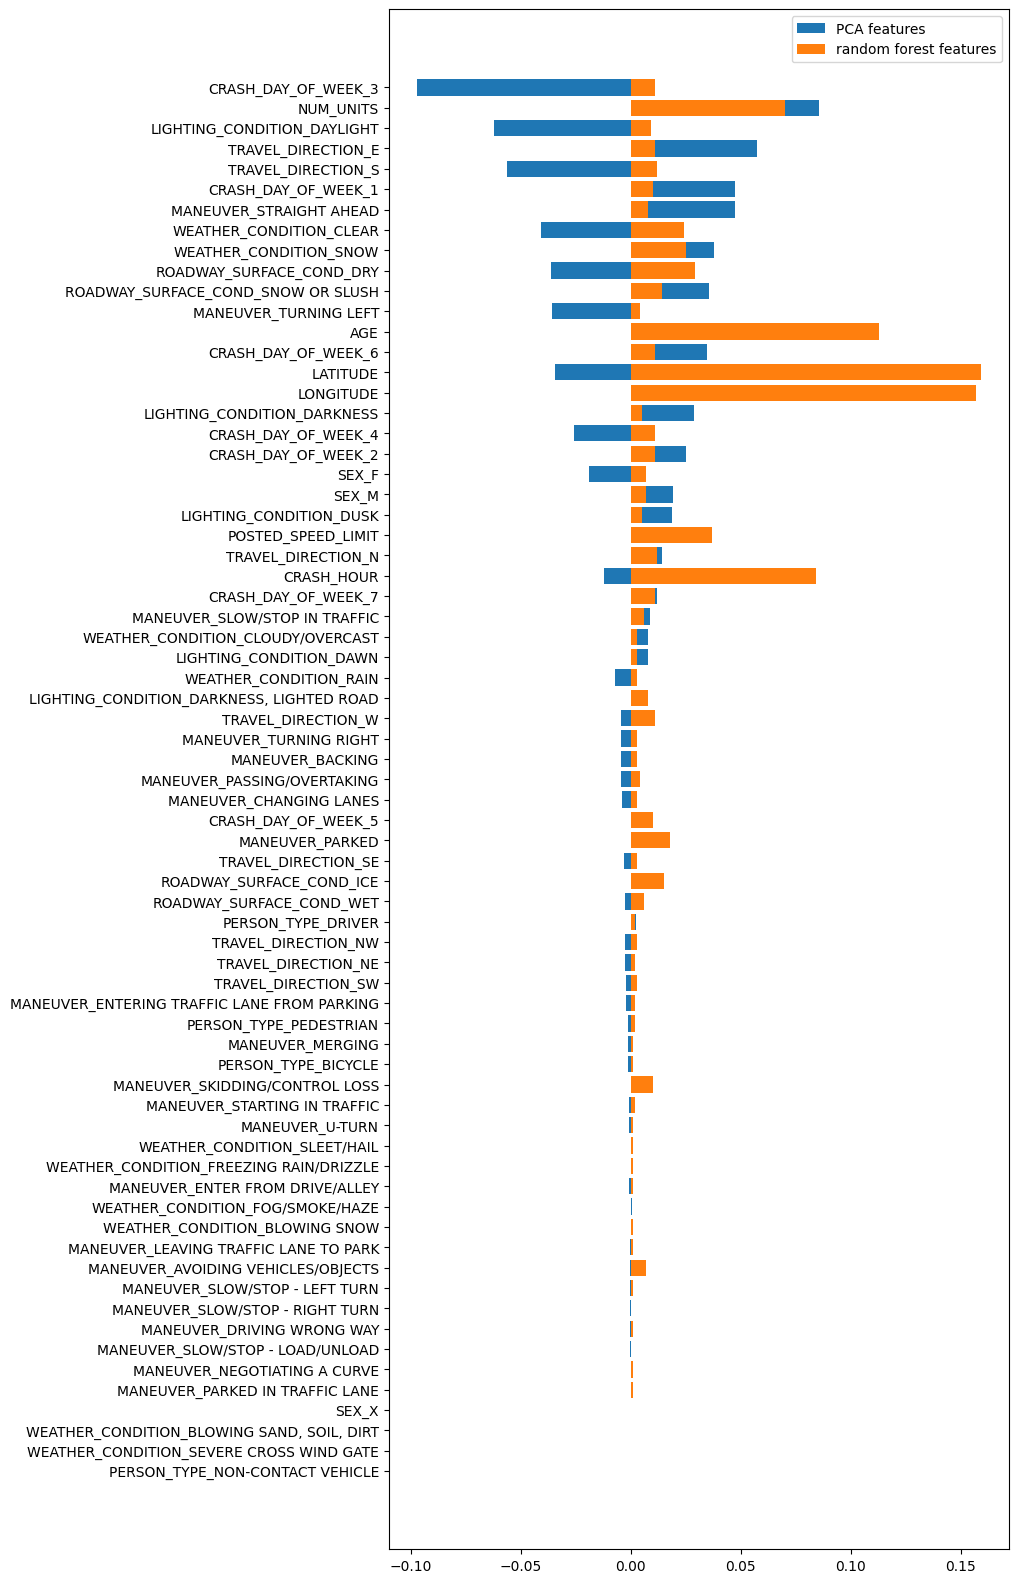

In [ ]:
fig, ax = plt.subplots(figsize=(8,20))
ax.barh(loadings_sums_scaled.index, loadings_sums_scaled.values, label='PCA features')
ax.barh(fi_series.index, fi_series.values, label='random forest features')
plt.legend();

PCA loadings and random forest features certainly show different perspectives on a lot of these columns. Generally speaking, though, they tend to agree on a *lot* of columns that don't seem to contribute much to variance or our target. Specifically, it appears that any columns at or below 'PERSON_TYPE_DRIVER' can be dropped, but we'll keep 'MANEUVER_SKIDDING/CONTROL LOSS' and 'MANEUVER_AVODING VEHICLES/OBJECTS' since the random forest is attributing some significance to them.

In [15]:
preliminary_columns_to_drop = ['PERSON_TYPE_DRIVER', 'TRAVEL_DIRECTION_NW', 'TRAVEL_DIRECTION_NE', 'TRAVEL_DIRECTION_SW', 'MANEUVER_ENTERING TRAFFIC LANE FROM PARKING',
                               'PERSON_TYPE_PEDESTRIAN', 'MANEUVER_MERGING', 'PERSON_TYPE_BICYCLE', 'MANEUVER_STARTING IN TRAFFIC', 'MANEUVER_U-TURN',
                               'WEATHER_CONDITION_SLEET/HAIL', 'WEATHER_CONDITION_FREEZING RAIN/DRIZZLE', 'MANEUVER_ENTER FROM DRIVE/ALLEY',
                               'WEATHER_CONDITION_FOG/SMOKE/HAZE', 'WEATHER_CONDITION_BLOWING SNOW', 'MANEUVER_LEAVING TRAFFIC LANE TO PARK',
                               'MANEUVER_SLOW/STOP - LEFT TURN', 'MANEUVER_SLOW/STOP - RIGHT TURN', 'MANEUVER_DRIVING WRONG WAY', 'MANEUVER_SLOW/STOP - LOAD/UNLOAD',
                               'MANEUVER_NEGOTIATING A CURVE', 'MANEUVER_PARKED IN TRAFFIC LANE', 'SEX_X', 'WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT',
                               'WEATHER_CONDITION_SEVERE CROSS WIND GATE', 'PERSON_TYPE_NON-CONTACT VEHICLE']

Now that we know which columns to run our white-box models with, we can drop them from our training data. Since we'll employ a Logistic Regression model and an individual decision tree model next, we'll actually need to drop these columns from the two training data sets. Both have the categorical variables one-hot encoded, but one has standardized numeric data (important for the Logit model) while the other's is not standardized (meant for the decision tree).

In [16]:
X_train_trimmed_and_stnd = X_train_preprocessed.drop(preliminary_columns_to_drop, axis=1)
X_train_trimmed_and_stnd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707817 entries, 571273 to 303626
Data columns (total 43 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   POSTED_SPEED_LIMIT                         707817 non-null  float64
 1   NUM_UNITS                                  707817 non-null  float64
 2   CRASH_HOUR                                 707817 non-null  float64
 3   LATITUDE                                   707817 non-null  float64
 4   LONGITUDE                                  707817 non-null  float64
 5   AGE                                        707817 non-null  float64
 6   WEATHER_CONDITION_CLEAR                    707817 non-null  float64
 7   WEATHER_CONDITION_CLOUDY/OVERCAST          707817 non-null  float64
 8   WEATHER_CONDITION_RAIN                     707817 non-null  float64
 9   WEATHER_CONDITION_SNOW                     707817 non-null  float64
 10  LIGHTING

In [17]:
X_train_timmed_and_non_stnd = X_train_nonstandardized.drop(preliminary_columns_to_drop, axis=1)
X_train_timmed_and_non_stnd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707817 entries, 571273 to 303626
Data columns (total 43 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   POSTED_SPEED_LIMIT                         707817 non-null  int64  
 1   NUM_UNITS                                  707817 non-null  int64  
 2   CRASH_HOUR                                 707817 non-null  int64  
 3   LATITUDE                                   707817 non-null  float64
 4   LONGITUDE                                  707817 non-null  float64
 5   AGE                                        707817 non-null  int64  
 6   WEATHER_CONDITION_CLEAR                    707817 non-null  float64
 7   WEATHER_CONDITION_CLOUDY/OVERCAST          707817 non-null  float64
 8   WEATHER_CONDITION_RAIN                     707817 non-null  float64
 9   WEATHER_CONDITION_SNOW                     707817 non-null  float64
 10  LIGHTING

# white-box predictive modeling

With an long process of column-trimming complete by way of domain knowledge (in the data engineering notebook) and through modeling (above), we can now fit our trimmed-down columns to two white-box models that will hopefully make sound predictions while remaining relatively simple to interpret for the non-technical stakeholder.

First, we'll run a StatsModels Logitistic Regression to see the statistical significance of each column.

In [ ]:
import statsmodels.api as sm
#adding the constant to X_train
X = sm.add_constant(X_train_trimmed_and_stnd)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
baseline_result = logit_model.fit(maxiter=3500)
#checking the results
baseline_result.summary()

Optimization terminated successfully.
         Current function value: 0.228359
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               707817
Model:                          Logit   Df Residuals:                   707776
Method:                           MLE   Df Model:                           40
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.1166
Time:                        22:17:43   Log-Likelihood:            -1.6164e+05
converged:                       True   LL-Null:                   -1.8296e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         0.8283        nan        nan        nan         nan         nan
POSTED_SPEED_LIMIT                        -1.363e-06      0.005     -0.000      1.000      -0.010       0.010
NUM_UNITS                                    -0.0027      0.004     -0.630      0.529      -0.011       0.006
CRASH_HOUR                                    0.1007      0.005     21.366      0.000       0.091       0.110
LATITUDE                                      0.3511      0.026     13.455      0.000       0.300       0.402
LONGITUDE                                     0.3514      0.027     13.230      0.000       0.299       0.403
AGE                                          -0.0318      0.005     -6.494      0.000      -0.041      -0.022
WEATHER_CONDITION_CLEAR                       0.9363      0.040     23.172      0.000       0.857       1.016
WEATHER_CONDITION_CLOUDY/OVERCAST             0.7683      0.046     16.586      0.000       0.677       0.859
WEATHER_CONDITION_RAIN                        0.1893      0.040      4.699      0.000       0.110       0.268
WEATHER_CONDITION_SNOW                        0.0055      0.041      0.134      0.893      -0.075       0.086
LIGHTING_CONDITION_DARKNESS                   0.2270        nan        nan        nan         nan         nan
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD     0.1426        nan        nan        nan         nan         nan
LIGHTING_CONDITION_DAWN                       0.0291        nan        nan        nan         nan         nan
LIGHTING_CONDITION_DAYLIGHT                   0.2349        nan        nan        nan         nan         nan
LIGHTING_CONDITION_DUSK                       0.1947        nan        nan        nan         nan         nan
ROADWAY_SURFACE_COND_DRY                      1.2492   5.38e+04   2.32e-05      1.000   -1.05e+05    1.05e+05
ROADWAY_SURFACE_COND_ICE                     -1.2347   5.37e+04   -2.3e-05      1.000   -1.05e+05    1.05e+05
ROADWAY_SURFACE_COND_SNOW OR SLUSH           -0.0545   5.38e+04  -1.01e-06      1.000   -1.05e+05    1.05e+05
ROADWAY_SURFACE_COND_WET                      0.8683   5.39e+04   1.61e-05      1.000   -1.06e+05    1.06e+05
CRASH_DAY_OF_WEEK_1                           0.1406        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_2                           0.0963        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_3                           0.0901        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_4                           0.1168        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_5                           0.1397        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_6                           0.0971        nan        nan        nan         nan         nan
CRASH_DAY_OF_WEEK_7                           0.147

These results are horrendous, but I think a big part of the problem is the fact that a few categorical columns in the dataset - 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION', and 'CRASH_DAY_OF_WEEK' - have not had any of their constituent one-hot encoded classes dropped yet, which results in multicollinearity issues. Subsequently, all three of these columns need to have an ohe-class column dropped. The silver lining is that we won't have to do this when we run the decision tree model.

In any case, [it's important to carefully consider *which* class to drop](https://towardsdatascience.com/drop-first-can-hurt-your-ols-regression-models-interpretability-4ca529cfb707) and not just arbitrarily drop the first one. Let's take a look at the first column in question:

In [ ]:
X_train_categorical['ROADWAY_SURFACE_COND'].value_counts()

ROADWAY_SURFACE_COND
DRY              561857
WET              113890
SNOW OR SLUSH     26159
ICE                5911
Name: count, dtype: int64

One one hand, we may think to drop the 'DRY' class because it's a go-to standard driving time that we'd be inclined to compare other, less common weather conditions to. However, dropping 'DRY' rows would also drop almost 80% of our rows, so let's *not* do that.

Fortunately, we do have grounds to drop the class with the most average coefficient among the road condition classes, which would be 'SNOW OR SLUSH' and that only results in a row loss of 4% - much more managable. Dropping this class means that we'll need to recognize that the remaining 'ROADWAY_SURFACE_COND' columns reference back to their median class of 'SNOW OR SLUSH'.

When looking at the lighting condition classes, we see the following:

In [ ]:
X_train_categorical['LIGHTING_CONDITION'].value_counts()

LIGHTING_CONDITION
DAYLIGHT                  492069
DARKNESS, LIGHTED ROAD    155616
DARKNESS                   26394
DUSK                       22094
DAWN                       11644
Name: count, dtype: int64

Again, we may consider dropping the 'DAYLIGHT' class since it represents the most common, unmarked, 'baseline' sort of lighting condition. However, dropping that class results in a *lot* of lost data. Instead, let's drop 'DUSK' since it represents the median coefficient value and doesn't result in nearly as much data being lost. Dropping this class means that we'll need to recognize that the remaining 'LIGHTING_CONDITION' columns reference back to their median class of 'DUSK'.

With that decided, let's also take a look at 'CRASH_DAY_OF_WEEK' value counts:

In [ ]:
X_train_categorical['CRASH_DAY_OF_WEEK'].value_counts()

CRASH_DAY_OF_WEEK
6    118376
5    104342
3    102897
4    102742
7    102254
2     96292
1     80914
Name: count, dtype: int64

This is not great news - the median coefficient class from our results puts '4' (Wednesday) as the median class, which will result in the loss of 102,742 rows from our data, but doing so will make our StatsModels Logit results interpretable, so we have to do it.

In [18]:
preliminary_columns_to_drop_for_statsmodels = ['ROADWAY_SURFACE_COND_SNOW OR SLUSH',
                                               'LIGHTING_CONDITION_DUSK',
                                               'CRASH_DAY_OF_WEEK_4']

In [ ]:
#dropping the classes
X_train_trimmed_and_stnd_for_Logit = X_train_trimmed_and_stnd.drop(preliminary_columns_to_drop_for_statsmodels, axis=1)
#refitting the model
X = sm.add_constant(X_train_trimmed_and_stnd_for_Logit)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
baseline_result = logit_model.fit(maxiter=3500)
#checking the results
baseline_result.summary()

Optimization terminated successfully.
         Current function value: 0.228359
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               707817
Model:                          Logit   Df Residuals:                   707776
Method:                           MLE   Df Model:                           40
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.1166
Time:                        22:17:53   Log-Likelihood:            -1.6164e+05
converged:                       True   LL-Null:                   -1.8296e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         1.0853      0.177      6.147      0.000       0.739       1.431
POSTED_SPEED_LIMIT                        -1.363e-06      0.005     -0.000      1.000      -0.010       0.010
NUM_UNITS                                    -0.0027      0.004     -0.630      0.529      -0.011       0.006
CRASH_HOUR                                    0.1007      0.005     21.366      0.000       0.091       0.110
LATITUDE                                      0.3511      0.026     13.455      0.000       0.300       0.402
LONGITUDE                                     0.3514      0.027     13.230      0.000       0.299       0.403
AGE                                          -0.0318      0.005     -6.494      0.000      -0.041      -0.022
WEATHER_CONDITION_CLEAR                       0.9363      0.040     23.172      0.000       0.857       1.016
WEATHER_CONDITION_CLOUDY/OVERCAST             0.7683      0.046     16.586      0.000       0.677       0.859
WEATHER_CONDITION_RAIN                        0.1893      0.040      4.699      0.000       0.110       0.268
WEATHER_CONDITION_SNOW                        0.0055      0.041      0.134      0.893      -0.075       0.086
LIGHTING_CONDITION_DARKNESS                   0.0323      0.036      0.897      0.370      -0.038       0.103
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD    -0.0521      0.029     -1.816      0.069      -0.108       0.004
LIGHTING_CONDITION_DAWN                      -0.1656      0.043     -3.896      0.000      -0.249      -0.082
LIGHTING_CONDITION_DAYLIGHT                   0.0402      0.028      1.444      0.149      -0.014       0.095
ROADWAY_SURFACE_COND_DRY                      1.3037      0.025     51.932      0.000       1.254       1.353
ROADWAY_SURFACE_COND_ICE                     -1.1802      0.033    -35.290      0.000      -1.246      -1.115
ROADWAY_SURFACE_COND_WET                      0.9228      0.025     37.102      0.000       0.874       0.972
CRASH_DAY_OF_WEEK_1                           0.0238      0.019      1.238      0.216      -0.014       0.061
CRASH_DAY_OF_WEEK_2                          -0.0205      0.018     -1.119      0.263      -0.056       0.015
CRASH_DAY_OF_WEEK_3                          -0.0267      0.018     -1.476      0.140      -0.062       0.009
CRASH_DAY_OF_WEEK_5                           0.0229      0.018      1.256      0.209      -0.013       0.059
CRASH_DAY_OF_WEEK_6                          -0.0197      0.018     -1.122      0.262      -0.054       0.015
CRASH_DAY_OF_WEEK_7                           0.0310      0.018      1.706      0.088      -0.005       0.067
SEX_F                                         0.0371      0.166      0.223      0.824      -0.289       0.363
SEX_M                                        -0.0925      0.166     -0.557      0.578      -0.418       0.233
TRAVEL_DIRECTION_E                            0.044

There are a ton of variables that aren't statisitically significant here (having a P>[z] value greater than 0.05). This does not necessarily mean we should drop them, too; sometimes they can help the model and we just don't drop too many conclusions from those features. However, with 42 columns in a StatsModels Logit model, we're still dealing with a lot of noise here.

Now that we have a real baseline, we can go through and also drop the features that are not statistically significant to finally get down to the factors that correlate with accidents that are avoidable, which would include the following.

This is a lot to drop, but we can already see that these columns have little to do with what makes an accident avoidable (and a solution actionable). Travel direction, gender, and day of the week have shown value counts with little variance among them, so it makes sense to see that they don't contribute much to our model.

In [19]:
insignificant_columns_to_drop = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'WEATHER_CONDITION_SNOW', 'LIGHTING_CONDITION_DARKNESS',
                   'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD', 'LIGHTING_CONDITION_DAYLIGHT', 'CRASH_DAY_OF_WEEK_1',
                   'CRASH_DAY_OF_WEEK_2', 'CRASH_DAY_OF_WEEK_3', 'CRASH_DAY_OF_WEEK_5', 'CRASH_DAY_OF_WEEK_6',
                   'CRASH_DAY_OF_WEEK_7', 'SEX_F', 'SEX_M', 'TRAVEL_DIRECTION_E', 'TRAVEL_DIRECTION_N',
                   'TRAVEL_DIRECTION_S', 'TRAVEL_DIRECTION_SE', 'TRAVEL_DIRECTION_W', 'MANEUVER_BACKING']

In [ ]:
#dropping the classes
X_train_trimmed_and_stnd_for_Logit = X_train_trimmed_and_stnd_for_Logit.drop(insignificant_columns_to_drop, axis=1)
#refitting the model
X = sm.add_constant(X_train_trimmed_and_stnd_for_Logit)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
statistically_significant_Logit = logit_model.fit(maxiter=3500)
#checking the results
statistically_significant_Logit.summary()

Optimization terminated successfully.
         Current function value: 0.228581
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               707817
Model:                          Logit   Df Residuals:                   707796
Method:                           MLE   Df Model:                           20
Date:                Sat, 18 May 2024   Pseudo R-squ.:                  0.1157
Time:                        22:18:00   Log-Likelihood:            -1.6179e+05
converged:                       True   LL-Null:                   -1.8296e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  1.1035      0.023     46.967      0.000       1.057       1.150
CRASH_HOUR                             0.0949      0.005     20.408      0.000       0.086       0.104
LATITUDE                               0.3252      0.026     12.517      0.000       0.274       0.376
LONGITUDE                              0.3259      0.026     12.318      0.000       0.274       0.378
AGE                                   -0.0308      0.005     -6.335      0.000      -0.040      -0.021
WEATHER_CONDITION_CLEAR                0.9353      0.023     40.306      0.000       0.890       0.981
WEATHER_CONDITION_CLOUDY/OVERCAST      0.7811      0.032     24.111      0.000       0.718       0.845
WEATHER_CONDITION_RAIN                 0.1897      0.024      7.837      0.000       0.142       0.237
LIGHTING_CONDITION_DAWN               -0.1863      0.033     -5.655      0.000      -0.251      -0.122
ROADWAY_SURFACE_COND_DRY               1.3100      0.025     53.446      0.000       1.262       1.358
ROADWAY_SURFACE_COND_ICE              -1.1769      0.033    -35.899      0.000      -1.241      -1.113
ROADWAY_SURFACE_COND_WET               0.9185      0.024     38.134      0.000       0.871       0.966
MANEUVER_AVOIDING VEHICLES/OBJECTS    -2.2117      0.043    -51.151      0.000      -2.296      -2.127
MANEUVER_CHANGING LANES                0.8668      0.059     14.720      0.000       0.751       0.982
MANEUVER_PARKED                       -1.5021      0.024    -61.604      0.000      -1.550      -1.454
MANEUVER_PASSING/OVERTAKING            1.0298      0.055     18.645      0.000       0.922       1.138
MANEUVER_SKIDDING/CONTROL LOSS        -2.1062      0.042    -49.946      0.000      -2.189      -2.024
MANEUVER_SLOW/STOP IN TRAFFIC         -0.4378      0.024    -18.552      0.000      -0.484      -0.392
MANEUVER_STRAIGHT AHEAD               -0.2901      0.020    -14.566      0.000      -0.329      -0.251
MANEUVER_TURNING LEFT                  0.0567      0.027      2.089      0.037       0.004       0.110
MANEUVER_TURNING RIGHT                -0.1270      0.033     -3.906      0.000      -0.191      -0.063
======================================================================================================
"""

Now we have a more reasonable model with all statisitically significant features. Before we try and optimize it via over/under-sampling, let's evaluate its performance via a confusion matrix to see how well it's predicting the target values in our test set.

In [20]:
#First, we need to reformat X_test to be comprable to X_train_trimmed_and_stnd_for_Logit.
# So far, we've reformatted X_test to include one-hot encoded categorical columns,
# but non-standardized numerical data, so we need to (1) standardize those columns,
# (2) bring in the categorical ones, then (3) drop every column we've dropped so far.

#transforming X_test numeric data
X_test_numeric_stnd = scaler.transform(X_test_numeric)
X_test_numeric_stnd = pd.DataFrame(X_test_numeric_stnd,
                                   columns=X_test_numeric.columns,
                                   index=X_test_numeric.index)

#bringing X_test's pre-ohe columns back in
X_test_trimmed_and_stnd_for_Logit = pd.concat([X_test_numeric_stnd, X_test_categorical_ohe], axis=1)

#dropping the columns we dropped from the training data
X_test_trimmed_and_stnd_for_Logit.drop(preliminary_columns_to_drop, axis=1, inplace=True)
X_test_trimmed_and_stnd_for_Logit.drop(preliminary_columns_to_drop_for_statsmodels, axis=1, inplace=True)
X_test_trimmed_and_stnd_for_Logit.drop(insignificant_columns_to_drop, axis=1, inplace=True)

X_test_trimmed_and_stnd_for_Logit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176955 entries, 442162 to 446367
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CRASH_HOUR                          176955 non-null  float64
 1   LATITUDE                            176955 non-null  float64
 2   LONGITUDE                           176955 non-null  float64
 3   AGE                                 176955 non-null  float64
 4   WEATHER_CONDITION_CLEAR             176955 non-null  float64
 5   WEATHER_CONDITION_CLOUDY/OVERCAST   176955 non-null  float64
 6   WEATHER_CONDITION_RAIN              176955 non-null  float64
 7   LIGHTING_CONDITION_DAWN             176955 non-null  float64
 8   ROADWAY_SURFACE_COND_DRY            176955 non-null  float64
 9   ROADWAY_SURFACE_COND_ICE            176955 non-null  float64
 10  ROADWAY_SURFACE_COND_WET            176955 non-null  float64
 11  MANEUVER_AVOIDING VEHICLES

In [ ]:
X_train_trimmed_and_stnd_for_Logit.shape

(707817, 20)

In [ ]:
X_test_trimmed_and_stnd_for_Logit.shape

(176955, 20)

In [ ]:
y_test.shape

(176955,)

In [ ]:
y_test.unique()

array([1, 0])

In [ ]:
X_test_trimmed_and_stnd_for_Logit['CONST'] = 1
#X_test_trimmed_and_stnd_for_Logit = X_test_trimmed_and_stnd_for_Logit.insert(0, 'CONST', 1)
#cols.insert(0, cols.pop(cols.index('Mid')))
X_test_trimmed_and_stnd_for_Logit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176955 entries, 442162 to 446367
Data columns (total 21 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CRASH_HOUR                          176955 non-null  float64
 1   LATITUDE                            176955 non-null  float64
 2   LONGITUDE                           176955 non-null  float64
 3   AGE                                 176955 non-null  float64
 4   WEATHER_CONDITION_CLEAR             176955 non-null  float64
 5   WEATHER_CONDITION_CLOUDY/OVERCAST   176955 non-null  float64
 6   WEATHER_CONDITION_RAIN              176955 non-null  float64
 7   LIGHTING_CONDITION_DAWN             176955 non-null  float64
 8   ROADWAY_SURFACE_COND_DRY            176955 non-null  float64
 9   ROADWAY_SURFACE_COND_ICE            176955 non-null  float64
 10  ROADWAY_SURFACE_COND_WET            176955 non-null  float64
 11  MANEUVER_AVOIDING VEHICLES

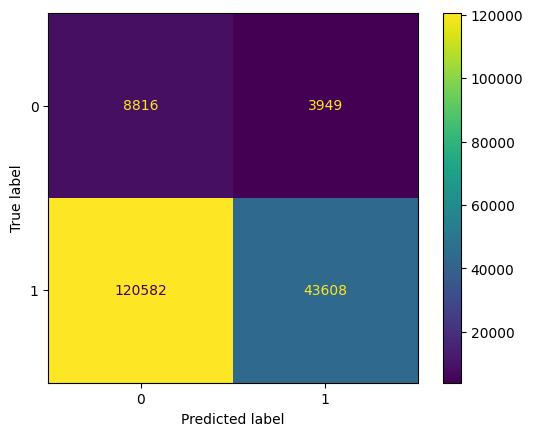

In [ ]:
#making our y_test predictions
y_pred_test = round(statistically_significant_Logit.predict(X_test_trimmed_and_stnd_for_Logit), 0)

#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred_test, target_names = target_names))

              precision    recall  f1-score   support

           0       0.07      0.69      0.12     12765
           1       0.92      0.27      0.41    164190

    accuracy                           0.30    176955
   macro avg       0.49      0.48      0.27    176955
weighted avg       0.86      0.30      0.39    176955



That is horrible, but it's almost certainly because we haven't yet addressed class imbalance.

In [ ]:
y_train.value_counts()

TARGET
1    656936
0     50881
Name: count, dtype: int64

In [ ]:
#refresher on the undersampling strategies
undersampling_strategies = [{0:50881, 1:328468}, {0:50881, 1:394162}, {0:50881, 1:459855}, {0:50881, 1:525549}, {0:50881, 1:591252}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in undersampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=210, sampling_strategy=i)
    # fit and apply the undersampling strategy
    X_train_trimmed_and_stnd_for_Logit_under, y_train_under = undersample.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
    #instantiate & fit the model to X-over & y-over
    X_under = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_under)
    temp_logit_model = sm.Logit(y_train_under.astype(float), X_under.astype(float))
    temp_logit_model = temp_logit_model.fit(maxiter=3500)
    #make predictions on test set
    y_hat = round(temp_logit_model.predict(X_under), 0)
    #find & append f1 score
    f1_scores.append(f1_score(y_train_under, y_hat))

undersampling_percentages = ['50%:', '60%:', '70%:', '80%:', '90%:']
print("sampling strategies & f1 scores:", list(zip(undersampling_percentages, f1_scores)))

Optimization terminated successfully.
         Current function value: 0.344437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.284951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244442
         Iterations 8
sampling strategies & f1 scores: [('50%:', 0.9307005155408586), ('60%:', 0.9414183235895568), ('70%:', 0.9491864566334836), ('80%:', 0.9550649734469039), ('90%:', 0.9596770318464387)]


Undersampling at 90% gets the best score so far, now let's try oversampling.

In [ ]:
#refresher on the oversampling strategies
oversampling_strategies = [{0:55969, 1:656936}, {0:61057, 1:656936}, {0:66145, 1:656936}, {0:71233, 1:656936}, {0:76322, 1:656936}]

#empty list for f1 scores
f1_scores = []

#iterate through each sampling strategy
for i in oversampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_trimmed_and_stnd_for_Logit_over, y_train_over = oversample.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
    #instantiate & fit the model to X-over & y-over
    X_over = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_over)
    temp_logit_model = sm.Logit(y_train_over.astype(float), X_over.astype(float))
    temp_logit_model = temp_logit_model.fit(maxiter=3500)
    #make predictions
    y_hat = round(temp_logit_model.predict(X_over), 0)
    #find & append f1 score
    f1_scores.append(f1_score(y_train_over, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

Optimization terminated successfully.
         Current function value: 0.242860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281639
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293242
         Iterations 8
sampling strategies & f1 scores: [('110%:', 0.9600413562503667), ('120%:', 0.9567278595924955), ('130%:', 0.95338885800407), ('140%:', 0.9501037296172755), ('150%:', 0.9468680997061669)]


Oversampling at 110% does even better. Finally, let's see the extent to which SMOTE oversampling will help.

In [ ]:
#empty list for f1 scores
f1_scores = []

#iterate through each SMOTE oversampling strategy
for i in oversampling_strategies:
    smote = SMOTE(random_state=210, sampling_strategy=i)
    # fit and apply the oversampling strategy
    X_train_trimmed_and_stnd_for_Logit_smote, y_train_smote = smote.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
    #instantiate & fit the model to X-smote & y-smote
    X_smote = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_smote)
    temp_logit_model = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
    temp_logit_model = temp_logit_model.fit(maxiter=3500)
    #make predictions
    y_hat = round(temp_logit_model.predict(X_smote), 0)
    #find & append f1 score
    f1_scores.append(f1_score(y_train_smote, y_hat))

oversampling_percentages = ['110%:', '120%:', '130%:', '140%:', '150%:']
print("sampling strategies & f1 scores:", list(zip(oversampling_percentages, f1_scores)))

Optimization terminated successfully.
         Current function value: 0.242916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256306
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269214
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293032
         Iterations 8
sampling strategies & f1 scores: [('110%:', 0.960048749296039), ('120%:', 0.95672112646407), ('130%:', 0.9534012470437719), ('140%:', 0.9501341923581175), ('150%:', 0.9468682179976415)]


A SMOTE oversampling strategy at 110% just barely outperforms our last-best strategy, so we'll use that.

Optimization terminated successfully.
         Current function value: 0.242916
         Iterations 8


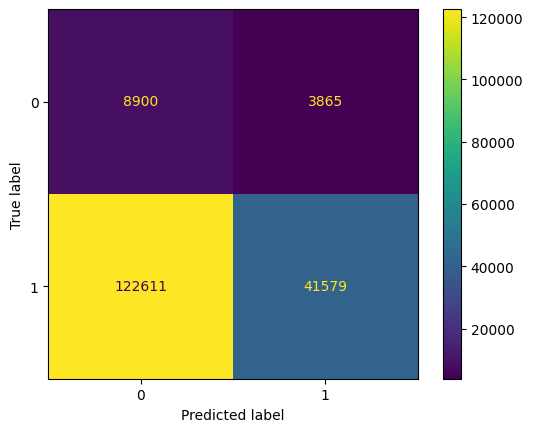

In [ ]:
#setting the SMOTE sampling_strategy to 110%
smote = SMOTE(random_state=210, sampling_strategy={0:55969, 1:656936})
#transforming our data
X_train_trimmed_and_stnd_for_Logit_smote, y_train_smote = smote.fit_resample(X_train_trimmed_and_stnd_for_Logit, y_train)
#instantiate & fit the model to X-smote & y-smote
X_smote = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_smote)
smote_logit_model = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
smote_logit_model = smote_logit_model.fit(maxiter=3500)

#making our test predictions
y_pred_test = round(smote_logit_model.predict(X_test_trimmed_and_stnd_for_Logit), 0)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = target_names))

              precision    recall  f1-score   support

           0       0.07      0.70      0.12     12765
           1       0.91      0.25      0.40    164190

    accuracy                           0.29    176955
   macro avg       0.49      0.48      0.26    176955
weighted avg       0.85      0.29      0.38    176955



Wow, oversampling didn't really improve our model. Let's try regularization since overfitting seems to be a problem when we compare the f1 scores of our train set (0.96) to our test set above.

In [ ]:
y_train_smote.shape

(712905,)

In [ ]:
X_train_trimmed_and_stnd_for_Logit_smote.shape

(712905, 20)

In [ ]:
X_smote.shape

(712905, 21)

In [ ]:
f1_scores = []

alpha_levels = [0.1, 0.5, 1, 2, 5, 10, 50]
for i in alpha_levels:
  X_smote = sm.add_constant(X_train_trimmed_and_stnd_for_Logit_smote)
  temp_model = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
  temp_model = temp_model.fit_regularized(maxiter=5000, method='l1', alpha=i, trim_mode='size')

  #make predictions
  y_hat = round(temp_model.predict(X_smote), 0)
  #find & append f1 score
  f1_scores.append(f1_score(y_train_smote, y_hat))

print("alpha levels & f1 scores:", list(zip(alpha_levels, f1_scores)))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2429199498778364
            Iterations: 141
            Function evaluations: 143
            Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24292939818526893
            Iterations: 270
            Function evaluations: 271
            Gradient evaluations: 270


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 8 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24294001437058532
            Iterations: 352
            Function evaluations: 352
            Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24296130086249887
            Iterations: 421
            Function evaluations: 426
            Gradient evaluations: 421


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24302750441877505
            Iterations: 393
            Function evaluations: 396
            Gradient evaluations: 393


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2431381205642659
            Iterations: 351
            Function evaluations: 355
            Gradient evaluations: 351


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 6 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2439975437406259
            Iterations: 237
            Function evaluations: 241
            Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


alpha levels & f1 scores: [(0.1, 0.960050919879652), (0.5, 0.9600502158813591), (1, 0.960045346518826), (2, 0.9600454637115254), (5, 0.9600456394992855), (10, 0.9600403592737969), (50, 0.960062522819216)]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2429199498778364
            Iterations: 141
            Function evaluations: 143
            Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 20 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)


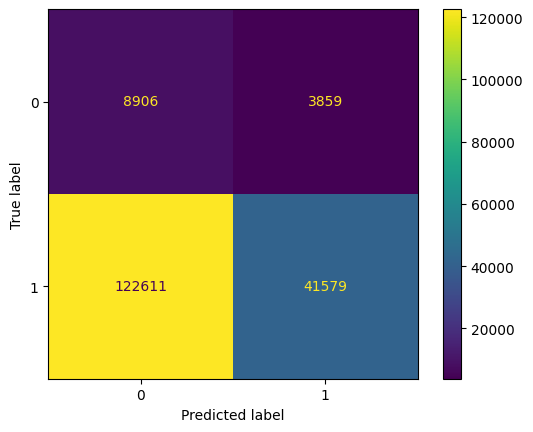

In [ ]:
#fitting with regularization and alpha set to 0.1
sm_logit_smote_reg = sm.Logit(y_train_smote.astype(float), X_smote.astype(float))
sm_logit_smote_reg = sm_logit_smote_reg.fit_regularized(maxiter=5000, method='l1', alpha=0.1, trim_mode='size')
#making our test predictions
y_pred_test = round(sm_logit_smote_reg.predict(X_test_trimmed_and_stnd_for_Logit), 0)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = target_names))

              precision    recall  f1-score   support

           0       0.07      0.70      0.12     12765
           1       0.92      0.25      0.40    164190

    accuracy                           0.29    176955
   macro avg       0.49      0.48      0.26    176955
weighted avg       0.85      0.29      0.38    176955



This model is still terrible, let's take a look at other ways we can improve it besides over/under-sampling and tuning the alpha hyperparameter.

In [ ]:
#fitting with regularization and alpha set to 0.1
temp_model = sm.Logit(y_train_smote.astype(float), X_train_preprocessed.astype(float))
temp_model = temp_model.fit_regularized(maxiter=5000,
                                        method='l1',
                                        alpha=0.1,
                                        trim_mode='size',
                                        C=1)
#making our test predictions
y_pred_test = round(temp_model.predict(X_test_preprocessed), 0)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

ValueError: The indices for endog and exog are not aligned

I give up, this model is too bad to use. I spent two days on this and all I have to show for it is a horribly inaccurate model. This sucks.

# Running a decision tree model

This is another white-box model we can use to make sense of this data in an interpretable manner. To begin, let's see how it performs with all 69 columns we began this notebook with.

In [ ]:
#gathering all categorical coulmns and non-standardized numeric ones
X_train_non_stnd_all_cat = pd.concat([X_train_numeric, X_train_categorical_ohe], axis=1)
X_train_non_stnd_all_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707817 entries, 571273 to 303626
Data columns (total 69 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   POSTED_SPEED_LIMIT                           707817 non-null  int64  
 1   NUM_UNITS                                    707817 non-null  int64  
 2   CRASH_HOUR                                   707817 non-null  int64  
 3   LATITUDE                                     707817 non-null  float64
 4   LONGITUDE                                    707817 non-null  float64
 5   AGE                                          707817 non-null  int64  
 6   WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT   707817 non-null  float64
 7   WEATHER_CONDITION_BLOWING SNOW               707817 non-null  float64
 8   WEATHER_CONDITION_CLEAR                      707817 non-null  float64
 9   WEATHER_CONDITION_CLOUDY/OVERCAST            707817 non-nul

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
#instantiating & fitting the DecisionTreeClassifier model
all_columns_dt = DecisionTreeClassifier(criterion='entropy', random_state=210)
all_columns_dt.fit(X_train_non_stnd_all_cat, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=210)

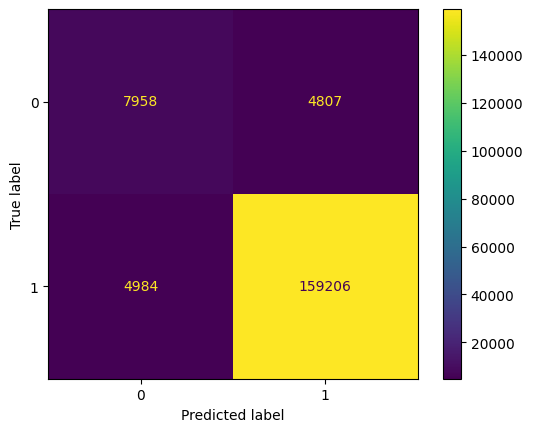

In [ ]:
#making our y_test predictions
y_pred_test_all = all_columns_dt.predict(X_test_nonstandardized)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_all);

In [ ]:
print(classification_report(y_test, y_pred_test_all, target_names = target_names))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62     12765
           1       0.97      0.97      0.97    164190

    accuracy                           0.94    176955
   macro avg       0.79      0.80      0.79    176955
weighted avg       0.95      0.94      0.94    176955



It looks like it's doing well except for the minority class in our target. This can hopefully be improved with over/under-sampling techniques, but for now, let's look at this model's feature importances.

In [ ]:
all_columns_feature_importances = all_columns_dt.feature_importances_
all_columns_feature_importances_rounded = np.around(all_columns_feature_importances, decimals=3)
all_columns_feature_importances_rounded = pd.Series(all_columns_feature_importances_rounded,
                                         index=X_train_non_stnd_all_cat.columns).sort_values()
print(all_columns_feature_importances_rounded.to_string())

PERSON_TYPE_NON-CONTACT VEHICLE                0.000
SEX_X                                          0.000
MANEUVER_DRIVING WRONG WAY                     0.000
WEATHER_CONDITION_SEVERE CROSS WIND GATE       0.000
WEATHER_CONDITION_BLOWING SNOW                 0.000
WEATHER_CONDITION_BLOWING SAND, SOIL, DIRT     0.000
ROADWAY_SURFACE_COND_SNOW OR SLUSH             0.000
MANEUVER_SLOW/STOP - LOAD/UNLOAD               0.000
MANEUVER_SLOW/STOP - RIGHT TURN                0.000
MANEUVER_SLOW/STOP - LEFT TURN                 0.001
MANEUVER_NEGOTIATING A CURVE                   0.001
MANEUVER_MERGING                               0.001
PERSON_TYPE_BICYCLE                            0.001
MANEUVER_ENTERING TRAFFIC LANE FROM PARKING    0.001
MANEUVER_ENTER FROM DRIVE/ALLEY                0.001
MANEUVER_CHANGING LANES                        0.001
TRAVEL_DIRECTION_NE                            0.001
MANEUVER_STARTING IN TRAFFIC                   0.001
PERSON_TYPE_PEDESTRIAN                        

That is a lot of features, so many of which contribute little to nothing for our model's predicting power. A long list like that also isn't exactly lending itself to model interpretability, so let's begin by reducing the columns to (almost) the same extent we did with StatsModels in order to see whether we can produce a more interpretable decision tree graph. We'll treat this as the actual baseline since it's the one we'll be optimizing from here on out.

In [32]:
X_train_nonstandardized_and_trimmed = X_train_nonstandardized.drop(preliminary_columns_to_drop, axis=1)

#Don't drop these three because decision trees don't have multicollinearity issues
#X_train_nonstandardized_and_trimmed.drop(preliminary_columns_to_drop_for_statsmodels, axis=1, inplace=True)

X_train_nonstandardized_and_trimmed.drop(insignificant_columns_to_drop, axis=1, inplace=True)

X_train_nonstandardized_and_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707817 entries, 571273 to 303626
Data columns (total 23 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CRASH_HOUR                          707817 non-null  int64  
 1   LATITUDE                            707817 non-null  float64
 2   LONGITUDE                           707817 non-null  float64
 3   AGE                                 707817 non-null  int64  
 4   WEATHER_CONDITION_CLEAR             707817 non-null  float64
 5   WEATHER_CONDITION_CLOUDY/OVERCAST   707817 non-null  float64
 6   WEATHER_CONDITION_RAIN              707817 non-null  float64
 7   LIGHTING_CONDITION_DAWN             707817 non-null  float64
 8   LIGHTING_CONDITION_DUSK             707817 non-null  float64
 9   ROADWAY_SURFACE_COND_DRY            707817 non-null  float64
 10  ROADWAY_SURFACE_COND_ICE            707817 non-null  float64
 11  ROADWAY_SURFACE_COND_SNOW 

In [33]:
#instantiating & fitting the DecisionTreeClassifier model
clf_baseline = DecisionTreeClassifier(criterion='entropy', random_state=210)
clf_baseline.fit(X_train_nonstandardized_and_trimmed, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=210)

In [34]:
X_test_nonstandardized_and_trimmed = X_test_nonstandardized.drop(preliminary_columns_to_drop, axis=1)
#X_test_nonstandardized_and_trimmed.drop(preliminary_columns_to_drop_for_statsmodels, axis=1, inplace=True)
X_test_nonstandardized_and_trimmed.drop(insignificant_columns_to_drop, axis=1, inplace=True)

X_test_nonstandardized_and_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176955 entries, 442162 to 446367
Data columns (total 23 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CRASH_HOUR                          176955 non-null  int64  
 1   LATITUDE                            176955 non-null  float64
 2   LONGITUDE                           176955 non-null  float64
 3   AGE                                 176955 non-null  int64  
 4   WEATHER_CONDITION_CLEAR             176955 non-null  float64
 5   WEATHER_CONDITION_CLOUDY/OVERCAST   176955 non-null  float64
 6   WEATHER_CONDITION_RAIN              176955 non-null  float64
 7   LIGHTING_CONDITION_DAWN             176955 non-null  float64
 8   LIGHTING_CONDITION_DUSK             176955 non-null  float64
 9   ROADWAY_SURFACE_COND_DRY            176955 non-null  float64
 10  ROADWAY_SURFACE_COND_ICE            176955 non-null  float64
 11  ROADWAY_SURFACE_COND_SNOW 

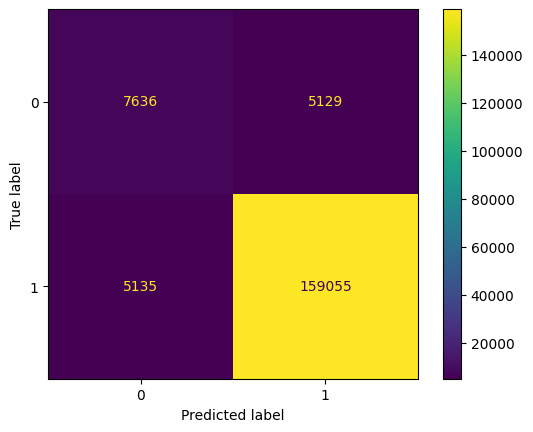

In [35]:
#making our y_test predictions
y_pred_test_baseline = clf_baseline.predict(X_test_nonstandardized_and_trimmed)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_baseline);

In [36]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred_test_baseline, target_names = target_names))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     12765
           1       0.97      0.97      0.97    164190

    accuracy                           0.94    176955
   macro avg       0.78      0.78      0.78    176955
weighted avg       0.94      0.94      0.94    176955



These results are quite similar to the model with all the features. There's just a slight decline by 0.02 in the minority class's precision & recall scores. However, it's a small price to pay to be able to reduce the features down to one-third of what they were. Let's examine this model's feature importances now.

In [39]:
#gathering its feature importances
baseline_importances = clf_baseline.feature_importances_
baseline_importances

array([0.10579679, 0.30084162, 0.28909221, 0.1366967 , 0.00695808,
       0.00301564, 0.00451798, 0.00440983, 0.00667801, 0.055294  ,
       0.00257913, 0.        , 0.01909848, 0.01763618, 0.0059495 ,
       0.0015767 , 0.01443965, 0.00247195, 0.00600312, 0.00428053,
       0.00471398, 0.00400144, 0.00394848])

In [40]:
baseline_importances_rounded = np.around(baseline_importances, decimals=3)
baseline_importances_rounded = pd.Series(baseline_importances_rounded,
                                         index=X_train_nonstandardized_and_trimmed.columns).sort_values()
baseline_importances_rounded

ROADWAY_SURFACE_COND_SNOW OR SLUSH    0.000
MANEUVER_PASSING/OVERTAKING           0.002
MANEUVER_CHANGING LANES               0.002
WEATHER_CONDITION_CLOUDY/OVERCAST     0.003
ROADWAY_SURFACE_COND_ICE              0.003
MANEUVER_SLOW/STOP IN TRAFFIC         0.004
MANEUVER_TURNING LEFT                 0.004
MANEUVER_TURNING RIGHT                0.004
LIGHTING_CONDITION_DAWN               0.004
WEATHER_CONDITION_RAIN                0.005
MANEUVER_STRAIGHT AHEAD               0.005
MANEUVER_AVOIDING VEHICLES/OBJECTS    0.006
MANEUVER_SKIDDING/CONTROL LOSS        0.006
LIGHTING_CONDITION_DUSK               0.007
WEATHER_CONDITION_CLEAR               0.007
MANEUVER_PARKED                       0.014
CRASH_DAY_OF_WEEK_4                   0.018
ROADWAY_SURFACE_COND_WET              0.019
ROADWAY_SURFACE_COND_DRY              0.055
CRASH_HOUR                            0.106
AGE                                   0.137
LONGITUDE                             0.289
LATITUDE                        

In [ ]:
len(X_train_nonstandardized_and_trimmed['LATITUDE'].value_counts())

138294

In [ ]:
len(X_train_nonstandardized_and_trimmed['LONGITUDE'].value_counts())

138182

In [ ]:
len(X_train_nonstandardized_and_trimmed['AGE'].value_counts())

108

In [ ]:
len(X_train_nonstandardized_and_trimmed['CRASH_HOUR'].value_counts())

24

In [41]:
len(X_train_nonstandardized_and_trimmed['ROADWAY_SURFACE_COND_DRY'].value_counts())

2

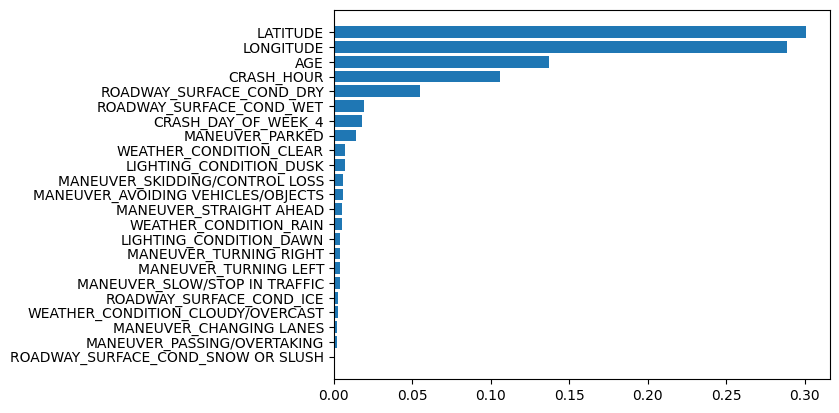

In [43]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.barh(baseline_importances_rounded.index, baseline_importances_rounded.values);